In [ ]:
pip install langgraph langchain-openai langchain-groq arxiv wikipedia langchain_community

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, AIMessage,AnyMessage
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [3]:
import os
os.environ["OPENAI_API_KEY"] = "your api key"
os.environ["TAVILY_API_KEY"] = "your api key"

In [4]:
api_wrap = ArxivAPIWrapper(top_k_results = 3,doc_content_chars_max = 4000)
Arxiv = ArxivQueryRun(api_wrapper=api_wrap)

In [5]:
api_wrap = WikipediaAPIWrapper(top_k_results = 3,doc_content_chars_max = 4000)
Wiki = WikipediaQueryRun(api_wrapper=api_wrap)

In [6]:
tavily = TavilySearchResults()

/tmp/ipython-input-2290291758.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [7]:
def add(a:int, b:int)-> int:
  """
  a: integer
  b:integer
  return a+b """
  return a+b

def mul(a:int, b:int)-> int:
  """
  a: integer
  b:integer
  return a*b """
  return a*b
def div(a:int, b:int)-> float:
  """
  a: integer
  b:integer
  return a/b """
  return a / b

In [8]:
tools = [Arxiv, Wiki,tavily,add,mul,div]

In [24]:
from langchain_openai import ChatOpenAI
llm_open = ChatOpenAI(model = "gpt-4o")

llm_bind_tools = llm_open.bind_tools(tools)

In [25]:
from pprint import pprint

In [26]:
llm_bind_tools.invoke([HumanMessage(content = "what is attention all you need")]).tool_calls

[{'name': 'arxiv',
  'args': {'query': 'attention is all you need'},
  'id': 'call_gnxpRBMrAmSGepJojqykeFnx',
  'type': 'tool_call'}]

In [27]:
class State(TypedDict):
  messages : Annotated[list[AnyMessage],add_messages]

In [28]:
def tool_calling(state : State):
  return {"messages" : [llm_bind_tools.invoke(state["messages"])]}

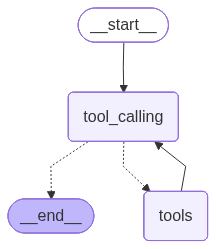

In [29]:
graph = StateGraph(State)

graph.add_node("tool_calling", tool_calling)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "tool_calling")
graph.add_conditional_edges("tool_calling", tools_condition,)
graph.add_edge("tools", "tool_calling")

graph_builder = graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [18]:
results = graph_builder.invoke({"messages" : [HumanMessage(content = "what is Machine Learning and give what is 10+20 and multipy by 5")]})
for m in results["messages"]:
   m.pretty_print()

================================ Human Message =================================

what is Machine Learning and give what is 10+20 and multipy by 5
================================== Ai Message ==================================
Tool Calls:
  wikipedia (ts7yvg2rg)
 Call ID: ts7yvg2rg
  Args:
    query: Machine Learning
  add (rkvjbx9cq)
 Call ID: rkvjbx9cq
  Args:
    a: 10
    b: 20
  mul (3srgv5wk7)
 Call ID: 3srgv5wk7
  Args:
    a: 30
    b: 5
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous 

In [14]:
graph = StateGraph(State)

graph.add_node("tool_calling", tool_calling)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "tool_calling")
graph.add_conditional_edges("tool_calling", tools_condition,)
graph.add_edge("tools", "tool_calling")

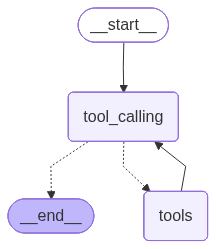

In [16]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph_memory = graph.compile(checkpointer=memory)

display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [30]:
config = {"configurable": {"thread_id" : "3"}}

message = [HumanMessage(content = "Add 5 and 6")]
results= graph_memory.invoke({"messages":message}, config = config)

for m in results["messages"]:
  m.pretty_print()

================================ Human Message =================================

Add 5 and 6
================================== Ai Message ==================================
Tool Calls:
  add (call_fIVVBbb96j3yKhsTExQeZbmB)
 Call ID: call_fIVVBbb96j3yKhsTExQeZbmB
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================

The sum of 5 and 6 is 11.


In [31]:
message = [HumanMessage(content = "Add 15 to the result number")]
results= graph_memory.invoke({"messages":message}, config = config)

for m in results["messages"]:
  m.pretty_print()

================================ Human Message =================================

Add 5 and 6
================================== Ai Message ==================================
Tool Calls:
  add (call_fIVVBbb96j3yKhsTExQeZbmB)
 Call ID: call_fIVVBbb96j3yKhsTExQeZbmB
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================

The sum of 5 and 6 is 11.
================================ Human Message =================================

Add 15 to the result number
================================== Ai Message ==================================
Tool Calls:
  add (call_FqKsyKEODr2mbNJiYePKI4Dn)
 Call ID: call_FqKsyKEODr2mbNJiYePKI4Dn
  Args:
    a: 11
    b: 15
================================= Tool Message =================================
Name: add

26
================================== Ai Message ==================================

Adding 15 to the res